# Homework \#3
Name: Jonas Schweisthal \
Student number: s4535561

In [8]:
from model import Model
from dmchunk import Chunk
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import math

In [9]:
def noise(s):
    rand = random.uniform(0.001,0.999)
    return s * math.log((1 - rand)/rand)

In [10]:
def time_to_pulses(time, t_0 = 0.011, a = 1.1, b = 0.015):
    pulses = 0
    pulse_duration = t_0
    while time >= pulse_duration:
        time = time - pulse_duration
        pulses += 1
        pulse_duration = a * pulse_duration + noise(b * a * pulse_duration)
    return pulses

In [11]:
def pulses_to_time(pulses, t_0 = 0.011, a = 1.1, b = 0.015):
    time = 0
    pulse_duration = t_0
    while pulses > 0:
        time = time + pulse_duration
        pulses = pulses - 1
        pulse_duration = a * pulse_duration + noise(b * a * pulse_duration)
    return time

In [12]:
def ready_set_go(n_participants, n_trials = 1500):
    subjects = range(1,n_participants+1)
    conditions = [1, 2, 3]
    trials = range(1,n_trials+1)
    
    df = pd.DataFrame(columns = ["Subj", "Cond", "line", "Trial", "Ts", "Tp", "Main"])
    main = False
    line = 0
    for subj in subjects:
        # shuffling order of conditions randomly per subject
        np.random.shuffle(conditions)
        for cond in conditions:
            # create a new model for each subject and condition as there's much time between testing the 
            # different conditions per subject
            m = Model()
            for trial in trials:
                line += 1
                # Checking if trial is training trial
                if trial > 500:
                    main = True
                else:
                    main = False
                # adding 1 second preparing time
                m.time += 1 
                # no exact infos for truncated exponential distribution of random delay in paper:
                # -> simplifed with continuos random uniform 
                delay = np.random.uniform(0.25, 0.85)
                m.time += delay
                # draw out of 11 discrete values of discrete uniform distribution per condition
                # rounding necessary for equalling overlapping values of conditions
                if cond == 1:
                    ts = np.random.choice(np.linspace(0.49409, 0.84701, 11).round(4))
                elif cond == 2:
                    ts = np.random.choice(np.linspace(0.67055, 1.0235, 11).round(4))
                elif cond == 3:
                    ts = np.random.choice(np.linspace(0.84701, 1.1999, 11).round(4))
                # adding interval time    
                m.time += ts
                # time to pulses 
                pulses = time_to_pulses(ts)
                fact = Chunk(name = "pf" + str(pulses), slots ={"isa":"pulses-fact", "pulses": pulses})
                # adding encounter of the perceived interval as pulses at the end time point of the presented interval
                m.add_encounter(fact)
                # adding time for storing encounter in memory
                m.time += .05
                # retrieving chunk with highest activation
                request = Chunk(name = "retrieve", slots = {"isa": "pulses-fact"})
                chunk, latency = m.retrieve(request)
                # adding encounter of the retrieved chunk
                m.add_encounter(chunk)
                # adding time for retrieving memory
                m.time += .05
                # adding latency of retrieved chunk
                m.time += latency
                pulses_retrieved = chunk.slots["pulses"] 
                # converting retrieved pulses to seconds
                tp = pulses_to_time(pulses_retrieved)
                # adding production time
                m.time += tp
                # storing times in milliseconds in dataframe
                df.loc[line-1] = [subj, cond, line, trial, ts*1000, tp*1000, main]
                
    return df, m

In [13]:
df, m = ready_set_go(5, n_trials = 1500)

C:\Users\jonas\AppData\Roaming\Python\Python37\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\jonas\AppData\Roaming\Python\Python37\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\jonas\AppData\Roaming\Python\Python37\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


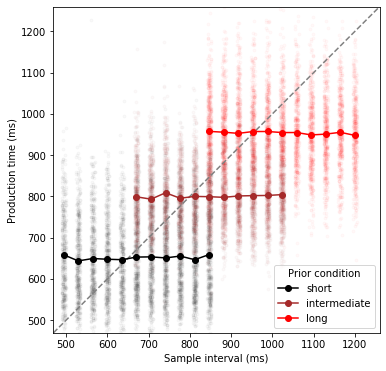

In [14]:
# Remove training trials
dat = df[df['Main'] == True]

# Calculate mean Tp by condition
mean_tp = dat.groupby(['Cond', 'Ts'])['Tp'].mean().reset_index()


yrange = np.multiply((min(mean_tp['Ts']), max(mean_tp['Ts'])), [0.95, 1.05])

# Subset data for plotting

cond1 = mean_tp.loc[mean_tp['Cond'] == 1]
cond2 = mean_tp.loc[mean_tp['Cond'] == 2]
cond3 = mean_tp.loc[mean_tp['Cond'] == 3]

# Add jitter noise
jitter = dat.copy()
jitter['Ts'] = jitter['Ts'] + np.random.uniform(-5, 5, len(dat))
cond1_jitter = jitter.loc[jitter['Cond'] == 1]
cond2_jitter = jitter.loc[jitter['Cond'] == 2]
cond3_jitter = jitter.loc[jitter['Cond'] == 3]

# Make plot
f, ax = plt.subplots(figsize = (6,6))

ax.set(xlim = yrange, ylim = yrange)
f.gca().set_aspect('equal', adjustable = 'box')

ax.set_xlabel('Sample interval (ms)')
ax.set_ylabel('Production time (ms)')

ax.plot(yrange, yrange, linestyle = '--', color ='gray')

ax.scatter(cond1_jitter['Ts'], cond1_jitter['Tp'], marker = '.', color = 'black', alpha = 0.025, label = None)
ax.scatter(cond2_jitter['Ts'], cond2_jitter['Tp'], marker = '.', color = 'brown', alpha = 0.025, label = None)
ax.scatter(cond3_jitter['Ts'], cond3_jitter['Tp'], marker = '.', color = 'red', alpha = 0.025, label = None)

ax.plot(cond1['Ts'], cond1['Tp'], color = 'black', marker = 'o', label = "short")
ax.plot(cond2['Ts'], cond2['Tp'], color = 'brown', marker = 'o', label = "intermediate")
ax.plot(cond3['Ts'], cond3['Tp'], color = 'red', marker = 'o', label = "long")

ax.legend(title = 'Prior condition', loc = 4)

In the graph in homework 2 the production times were defined as the sample intervals and were therefore on the bisector. Thus, expected higher production times for higher sample intervals, independent on the conditions. 

Here in homework 3: Within the conditions the condition specific mean value for almost every sample interval can be considered as production time, but there are big differences between the conditions. This is probably due to the fact that for each new condition a new model is initialized for each subject and that after the 500 training trials the activation of each pulse chunk in memory is so high that especially the noise of the activations has a great influence on the choice of the retrieved chunk, which makes it nearly random choice within the conditions. Additionally, higher deviations within the higher conditions are visible, due to logistic noise in time_to_pulses and pulses_to_time fuctions.

The graph in the paper shows an approximation to the mean value per condition, especially for the longer conditions, but there is still an individual increase within the conditions. Probably a middle course of the two homeworks in the form of blended traces could lead to a more similar result.
